In [1]:
from IPython.display import clear_output
!pip install -qU --upgrade pip
!pip install -qU scikit-learn
!pip install -qU wandb
clear_output()


In [2]:
!pip install -q /lib/wheels/tensorflow-2.9.1-cp38-cp38-linux_x86_64.whl
!pip install -q tensorflow-addons==0.18.0
!pip install -q tensorflow-probability==0.17.0
!pip install -q opencv-python-headless
!pip install -q seaborn
!pip install -q plotly

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-text 2.11.0 requires tensorflow<2.12,>=2.11.0; platform_machine != "arm64" or platform_system != "Darwin", but you have tensorflow 2.9.1 which is incompatible.


In [3]:
!pip install -qU pydot
!pip install graphviz

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.0/47.0 kB 2.3 MB/s eta 0:00:00


In [4]:
#Basic python libraries
%config Completer.use_jedi = False
import os, re, math, random, shutil, warnings, gc
import glob
import numpy as np, pandas as pd
from IPython import display as ipd
from tqdm import tqdm

#Classical Ml tools
import sklearn
from sklearn.model_selection import StratifiedGroupKFold
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve, auc
from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import train_test_split

#OpenCV Library
import cv2

#Plotting tools 
from matplotlib.ticker import StrMethodFormatter
from mpl_toolkits.axes_grid1 import ImageGrid
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import plotly.express as px
import plotly.offline as py
import plotly.figure_factory as ff
from plotly.subplots import make_subplots

#Tensorflow and keras tools
import tensorflow as tf
from tensorflow import keras
import tensorflow.keras.backend as K
from keras.models import Sequential,load_model,Model
from keras.layers import Conv2D,MaxPooling2D,Dense,Dropout,BatchNormalization,Flatten,Input
from keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import image_dataset_from_directory,plot_model
from tensorflow.python.client import device_lib
from tensorflow.keras.layers.experimental.preprocessing import Rescaling
from tensorflow.keras.applications import EfficientNetB3
from keras.callbacks import EarlyStopping

from kaggle_datasets import KaggleDatasets
from kaggle_secrets import UserSecretsClient

#Logging tools
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' # to avoid too many logging messages
pd.options.mode.chained_assignment = None
tf.get_logger().setLevel('ERROR')
py.init_notebook_mode(connected=True)

[percpu.cc : 560] RAW: rseq syscall failed with errno 1
[percpu.cc : 552] RAW: rseq syscall failed with errno 1


In [5]:
print('np:', np.__version__)
print('pd:', pd.__version__)
print('sklearn:', sklearn.__version__)
print('tf:',tf.__version__)

np: 1.24.1
pd: 1.5.3
sklearn: 1.2.2
tf: 2.9.1


In [6]:
import wandb

try:
    # Step 1: Get the credential from the Cloud SDK
    from kaggle_secrets import UserSecretsClient
    user_secrets = UserSecretsClient()
    user_credential = user_secrets.get_gcloud_credential()
    
    # Step 2: Set the credentials
    user_secrets.set_tensorflow_credential(user_credential)
    
    api_key = user_secrets.get_secret("WANDB")
    wandb.login(key=api_key)
    anonymous = None
except:
    anonymous = "must"
    print('To use your W&B account,\nGo to Add-ons -> Secrets and provide your W&B access token.\
    Use the Label name as WANDB. \nGet your W&B access token from here: https://wandb.ai/authorize')

To use your W&B account,
Go to Add-ons -> Secrets and provide your W&B access token.    Use the Label name as WANDB. 
Get your W&B access token from here: https://wandb.ai/authorize


In [7]:
devices = ['TPU', 'GPU']
img_size = [(1024,512), (512,256)]
img_ext = ['png']

class Config:
    
    def __init__(self):
        
        self.wandb = False
        self.competition   = 'rsna-bcd' 
        self._wandb_kernel = 'Gebreyowhans'
        
        self.debug = True

#         self.model_name = 'EfficientNetV1B3'
        
        self.device=devices[0]
        self.seed=150
        
        self.path='/kaggle/input/rsna-bcd-converted-dicom-images/'
        self.train_path= self.path+'train_images'
        self.train_path = self.path + 'train_images/'
        self.train_csv = self.path + 'train.csv'
        self.weights = "/kaggle/input/efficientnetb3-notop/efficientnetb3_notop.h5"
        
        self.output_path='/kaggle/working/'
        #number of folds for data-split
        self.folds = 5
        # which folds to train
        self.train_folds = [0, 1, 2]
        
        self.oversampling = True
        self.oversampling_factor = 10
        self.threshold = 0.6
        
        #Model Parameters
        self.batch_size=32
        self.epochs=12
        self.dropout=0.05
        self.optimizer='adam'
        self.loss='binary_crossentropy'
        self.patience=5
        self.img_size = img_size[1]
        self.img_ext = img_ext[0] 
        
        # ======Augumentation parameters====
        # pixel-augment
        self.sat  = [0.7, 1.3]
        self.cont = [1,2]
        self.bri  = 0.15
        self.hue  = 0.05

    

config=Config()

In [8]:
def seeding(seed):
#     os.environ['PYTHONHASHSEED'] = str(seed)
#     os.environ['TF_DETERMINISTIC_OPS'] = str(seed)
#     os.environ['TF_CUDNN_DETERMINISTIC'] = str(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)
    random.seed(seed)
    
    print("Seeding done")
    
seeding(config.seed)

Seeding done


In [9]:
if config.device == 'TPU':
    
    tpu = 'local' if config.device=='TPU' else None
    print('Connecting to TPU...')
    try:
        tpu = tf.distribute.cluster_resolver.TPUClusterResolver.connect(tpu=tpu)
    except ValueError:
        raise BaseException('ERROR: Not connected to a TPU runtime; please try executing it again or turnon your TPU VM v3-8 in your accelrator section of this note book !')
    
    policy =tf.keras.mixed_precision.Policy('float32') 
    tf.keras.mixed_precision.set_global_policy(policy)
    
    tf.config.set_soft_device_placement(True)
    #strategy = tf.distribute.experimental.TPUStrategy(tpu)
    strategy = tf.distribute.TPUStrategy(tpu)
    
    # TPU has to access the dataset from Google Cloud storage(GCS), so we have to set our path to GCS path
    config.path = KaggleDatasets().get_gcs_path(config.path.split('/')[3])
    config.train_path = config.path + '/' + 'train_images/'
    
    # get number of TPU cores connect at a runtime
    config.num_devices = strategy.num_replicas_in_sync
    
    # batch size of for the TPU
    config.batch_size = config.batch_size * config.num_devices
    print("Batch size for TPU :",config.batch_size)
    print(f'Running on {config.num_devices} TPU devices')


if config.device == 'GPU':
    
    #Number of GPU core connected
    num_devices = len(tf.config.list_physical_devices('GPU'))
    if num_devices > 1:
        config.num_devices = num_devices
        strategy = tf.distribute.MirroredStrategy()
        config.batch_size = config.batch_size * config.num_devices
        print(f'Running on {num_devices} GPU devices')
        print("Batch size for multi core GPU :",config.batch_size )
        
    elif num_devices == 1:
        strategy = tf.distribute.get_strategy()
        print(f'Running on {num_devices} GPU device')
        
    else:
        strategy = tf.distribute.get_strategy()
        config.device = 'CPU'
        print(f'Running on CPU')
    
    tf.config.optimizer.set_jit(True)
    tf.keras.mixed_precision.set_global_policy("mixed_float16")

Connecting to TPU...
Batch size for TPU : 256
Running on 8 TPU devices


In [10]:
train_df = pd.read_csv(config.train_csv)

if config.debug:
    train_df = train_df.sample(1000).reset_index(drop=True)

In [11]:
train_df['image_path'] = config.train_path + train_df['patient_id'].astype(str) + '/' + train_df['image_id'].astype(str) + '.png'

In [12]:
tf.io.gfile.exists(train_df.image_path.iloc[0])

True

In [13]:
train_df.head()

,site_id,patient_id,image_id,laterality,view,age,cancer,biopsy,invasive,BIRADS,implant,density,machine_id,difficult_negative_case,image_path
0,1,5630,528001627,L,MLO,47.0,0,1,0,0.0,0,C,49,True,gs://kds-e7efacccb5eb3987d63db1718eb67c141ef76...
1,2,14578,1372447740,L,CC,59.0,0,0,0,NaN,0,NaN,48,False,gs://kds-e7efacccb5eb3987d63db1718eb67c141ef76...
2,2,56146,1582720974,L,MLO,65.0,0,0,0,NaN,0,NaN,48,False,gs://kds-e7efacccb5eb3987d63db1718eb67c141ef76...
3,1,62608,630693798,L,CC,72.0,1,1,1,0.0,1,B,49,False,gs://kds-e7efacccb5eb3987d63db1718eb67c141ef76...
4,2,31148,1668075471,R,CC,43.0,0,0,0,NaN,0,NaN,48,False,gs://kds-e7efacccb5eb3987d63db1718eb67c141ef76...


In [14]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 15 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   site_id                  1000 non-null   int64  
 1   patient_id               1000 non-null   int64  
 2   image_id                 1000 non-null   int64  
 3   laterality               1000 non-null   object 
 4   view                     1000 non-null   object 
 5   age                      999 non-null    float64
 6   cancer                   1000 non-null   int64  
 7   biopsy                   1000 non-null   int64  
 8   invasive                 1000 non-null   int64  
 9   BIRADS                   460 non-null    float64
 10  implant                  1000 non-null   int64  
 11  density                  519 non-null    object 
 12  machine_id               1000 non-null   int64  
 13  difficult_negative_case  1000 non-null   bool   
 14  image_path               

# 9.Handle missing values 

In [15]:
def filter_missing_Features(df):
    total_missing_data= df.isnull().sum().sort_values(ascending = False)
    percentage_of_missing = (df.isnull().sum()/df.isnull().count()).sort_values(ascending = False)
    return pd.concat([total_missing_data,percentage_of_missing] , axis = 1 , keys = ['total_missing_data' , 'percentage_of_missing'])

In [16]:
filter_missing_Features(train_df)

,total_missing_data,percentage_of_missing
BIRADS,540,0.540
density,481,0.481
age,1,0.001
site_id,0,0.000
patient_id,0,0.000
image_id,0,0.000
laterality,0,0.000
view,0,0.000
cancer,0,0.000
biopsy,0,0.000


* BIRADS Columun have almost half missing and we don't know how to fill it so we decided better to remove this feature
* The Age Columun also have very few missing values and we decided to fill these missing with average age value of the others

* Density Columun have also almost half of missing data and we decided to fill it with other category labeld 'E'

In [17]:
train_df = train_df.drop(['BIRADS'], axis=1)
train_df['age'] = train_df['age'].fillna(train_df['age'].mean())
train_df['density'] = train_df['density'].fillna('E')

In [18]:
filter_missing_Features(train_df)

,total_missing_data,percentage_of_missing
site_id,0,0.0
patient_id,0,0.0
image_id,0,0.0
laterality,0,0.0
view,0,0.0
age,0,0.0
cancer,0,0.0
biopsy,0,0.0
invasive,0,0.0
implant,0,0.0


# 10. Fix Data Types 

In [19]:
train_df['laterality'] = train_df['laterality'].astype('category')
train_df['view'] = train_df['view'].astype('category')
train_df['age'] = train_df['age'].astype('int64')
train_df['density'] = train_df['density'].astype('category')
train_df['image_path'] = train_df['image_path'].astype('string')
train_df['cancer'] = train_df['cancer'].astype('float32')

In [20]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 14 columns):
 #   Column                   Non-Null Count  Dtype   
---  ------                   --------------  -----   
 0   site_id                  1000 non-null   int64   
 1   patient_id               1000 non-null   int64   
 2   image_id                 1000 non-null   int64   
 3   laterality               1000 non-null   category
 4   view                     1000 non-null   category
 5   age                      1000 non-null   int64   
 6   cancer                   1000 non-null   float32 
 7   biopsy                   1000 non-null   int64   
 8   invasive                 1000 non-null   int64   
 9   implant                  1000 non-null   int64   
 10  density                  1000 non-null   category
 11  machine_id               1000 non-null   int64   
 12  difficult_negative_case  1000 non-null   bool    
 13  image_path               1000 non-null   string  
dtypes: bool(1

# 11. Numerical Categorization

In [21]:
train_df["age_bin"] = pd.cut(train_df['age'].values.reshape(-1), bins=5, labels=False)

# 12. Generate dummy variables 

In [22]:
cat_cols = ['laterality', 'view', 'density', 'difficult_negative_case']
train_df = pd.get_dummies(train_df, columns=cat_cols)

# 13. Stratified K-Fold Cross Validation 

* Stratified k-fold cross-validation is the same as just k-fold cross-validation, but Stratified k-fold  cross-validation, it does stratified sampling instead of random sampling. 

* This is particularly useful when dealing with imbalanced datasets, where one class or outcome variable is much more prevalent than the others.
* Without stratification, a standard K-Fold Cross Validation could lead to some folds containing little or no instances of the minority class, which would bias the evaluation of the model's performance.
* So since our dataset is highly imbalanced we decided to use this kind of cros validatio.

In [23]:
train_df.head(3)

,site_id,patient_id,image_id,age,cancer,biopsy,invasive,implant,machine_id,image_path,...,laterality_R,view_CC,view_MLO,density_A,density_B,density_C,density_D,density_E,difficult_negative_case_False,difficult_negative_case_True
0,1,5630,528001627,47,0.0,1,0,0,49,gs://kds-e7efacccb5eb3987d63db1718eb67c141ef76...,...,0,0,1,0,0,1,0,0,0,1
1,2,14578,1372447740,59,0.0,0,0,0,48,gs://kds-e7efacccb5eb3987d63db1718eb67c141ef76...,...,0,1,0,0,0,0,0,1,1,0
2,2,56146,1582720974,65,0.0,0,0,0,48,gs://kds-e7efacccb5eb3987d63db1718eb67c141ef76...,...,0,0,1,0,0,0,0,1,1,0


In [24]:
stratified_columns = train_df.columns[~train_df.columns.isin(['patient_id', 'image_id', 
                                                              'image_path', 'target', 
                                                              'site_id', 'width', 'height', 
                                                              'age', 'invasive', 
                                                              'implant', 'machine_id'])]

train_df['stratify'] = ''
for col in stratified_columns:
    train_df['stratify'] += train_df[col].astype(str)
     

train_df['stratify'] = train_df['stratify'].astype('string')

k_fold = StratifiedGroupKFold(n_splits=config.folds, shuffle=True, random_state=config.seed)


for fold, (train_idx, val_idx) in enumerate(k_fold.split(train_df, train_df['stratify'], train_df['patient_id'])):
    train_df.loc[val_idx, 'fold'] = fold

train_df['fold'] = train_df['fold'].astype('int32')

/usr/local/lib/python3.8/site-packages/sklearn/model_selection/_split.py:909: UserWarning:

The least populated class in y has only 1 members, which is less than n_splits=5.



In [25]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 24 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   site_id                        1000 non-null   int64  
 1   patient_id                     1000 non-null   int64  
 2   image_id                       1000 non-null   int64  
 3   age                            1000 non-null   int64  
 4   cancer                         1000 non-null   float32
 5   biopsy                         1000 non-null   int64  
 6   invasive                       1000 non-null   int64  
 7   implant                        1000 non-null   int64  
 8   machine_id                     1000 non-null   int64  
 9   image_path                     1000 non-null   string 
 10  age_bin                        1000 non-null   int64  
 11  laterality_L                   1000 non-null   uint8  
 12  laterality_R                   1000 non-null   ui

In [26]:
print(train_df.groupby(['fold', "cancer"]).size())

fold  cancer
0     0.0       202
      1.0         4
1     0.0       195
      1.0         2
2     0.0       194
      1.0         3
3     0.0       196
      1.0         4
4     0.0       195
      1.0         5
dtype: int64


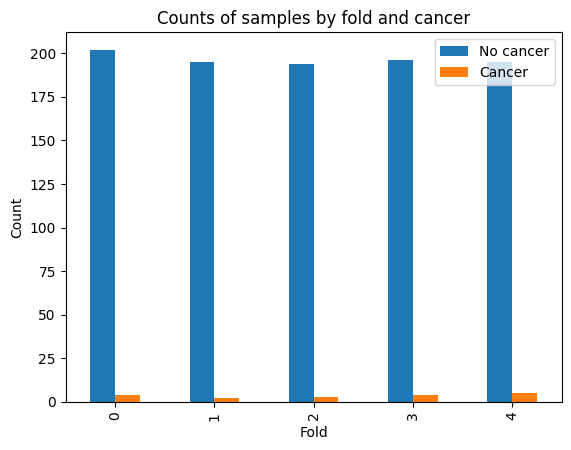

In [27]:
# reshape the data into a pivot table
counts = train_df.groupby(['fold', 'cancer']).size().unstack()

# plot the pivot table as a bar graph
counts.plot(kind='bar')
plt.xlabel('Fold')
plt.ylabel('Count')
plt.title('Counts of samples by fold and cancer')
plt.legend(['No cancer', 'Cancer'])
plt.show()


# 14. Build Dataset in the form of TF.Data.Dataset

**14.1 Decode images**
 * **tf.image.decode_png()** and **tf.image.decode_jpeg** are TensorFlow functions that decodes a PNG-encoded   image into a tensor of type uint8.
 
 * These functions takes the following arguments: 
     * **image**: A string tensor containing a PNG or jpeg -encoded image.
     * **channels**: An optional integer specifying the number of color channels in the decoded image. By  default, this is set to 3,
     

* The function returns a **uint8** tensor representing the decoded image with the shape of (height, width, channels) 
 


In [28]:
def decode_image(label=True, img_size=config.img_size, ext=config.img_ext):
    
    def _decode_image(Input_Image, label=None):
        image = tf.io.read_file(Input_Image['input_image'])
        
        if ext == 'png':
            ## PNG-encoded image into a tensor of type uint8.
            image = tf.image.decode_png(image, channels=3)
        elif ext in ['jpg', 'jpeg']:
            ## jpeg-encoded image into a tensor of type uint8.
            image = tf.image.decode_jpeg(image, channels=3)
        else:
            raise ValueError("Image extension not supported")
        
        ## explicit size needed for TPU
        image = tf.image.resize(image, img_size)
        ## convert image to floats in [0, 1] range
        image = tf.cast(image, tf.float32) / 255.0
        
        Input_Image['input_image'] = image
        
        if label is None:
            return Input_Image
        else:
            return Input_Image, label
    
    if label:
        return _decode_image
    else:
        return lambda x: _decode_image(x, None)

* 14.2 Data augumentation

In [29]:
def data_augment(label=True):
    def _augment(Input_Image, label=None):
        image = Input_Image['input_image']
        #position transforamtion
        image = tf.image.random_flip_left_right(image)
        # pixel-augment
        image = tf.image.random_hue(image, config.hue)
        image = tf.image.random_saturation(image,config.sat[0], config.sat[1])
        image = tf.image.random_contrast(image,config.cont[0], config.cont[1])
        image = tf.image.random_brightness(image,config.bri)
        Input_Image['input_image'] = image
        if label is not None:
            return Input_Image, label
        else:
            return Input_Image

    if label:
        return _augment
    else:
        return lambda x: _augment(x, None)


In [30]:
def build_dataset(df, input_features, image_size=config.img_size, batch_size=config.batch_size, 
                  label=True, shuffle=True, augment=False, repeat=False, cache=False, ext=config.img_ext):
    
    decode = decode_image(label, img_size=image_size, ext=ext)

    input_data = {'input_image': df['image_path'].values, 'input_features': df[input_features].values}
    
    if label:
        label_data = df['cancer'].apply(lambda x: int(x)).values
        dataset = tf.data.Dataset.from_tensor_slices((input_data, label_data))
    else:
        dataset = tf.data.Dataset.from_tensor_slices(input_data)

    dataset = dataset.map(decode, num_parallel_calls=tf.data.AUTOTUNE)
    
    if augment:
        dataset = dataset.map(data_augment(label), num_parallel_calls=tf.data.AUTOTUNE)
    if shuffle:
        dataset = dataset.shuffle(batch_size, reshuffle_each_iteration=True)
    if repeat:
        dataset = dataset.repeat()
    if cache:
        dataset = dataset.cache()
        
    dataset = dataset.batch(batch_size, drop_remainder=shuffle)
    dataset = dataset.prefetch(tf.data.AUTOTUNE)
    return dataset


# 15. Input Features

In [31]:
input_features = train_df.columns.difference(['patient_id', 'image_id', 'site_id', 'machine_id',
                                              'width', 'height', 'cancer', 'age', 
                                              'stratify', 'image_path', 'fold'])

In [32]:
print(input_features)

Index(['age_bin', 'biopsy', 'density_A', 'density_B', 'density_C', 'density_D',
       'density_E', 'difficult_negative_case_False',
       'difficult_negative_case_True', 'implant', 'invasive', 'laterality_L',
       'laterality_R', 'view_CC', 'view_MLO'],
      dtype='object')


# 16. Some augumented and non augumented images

Number of images in batch :  2


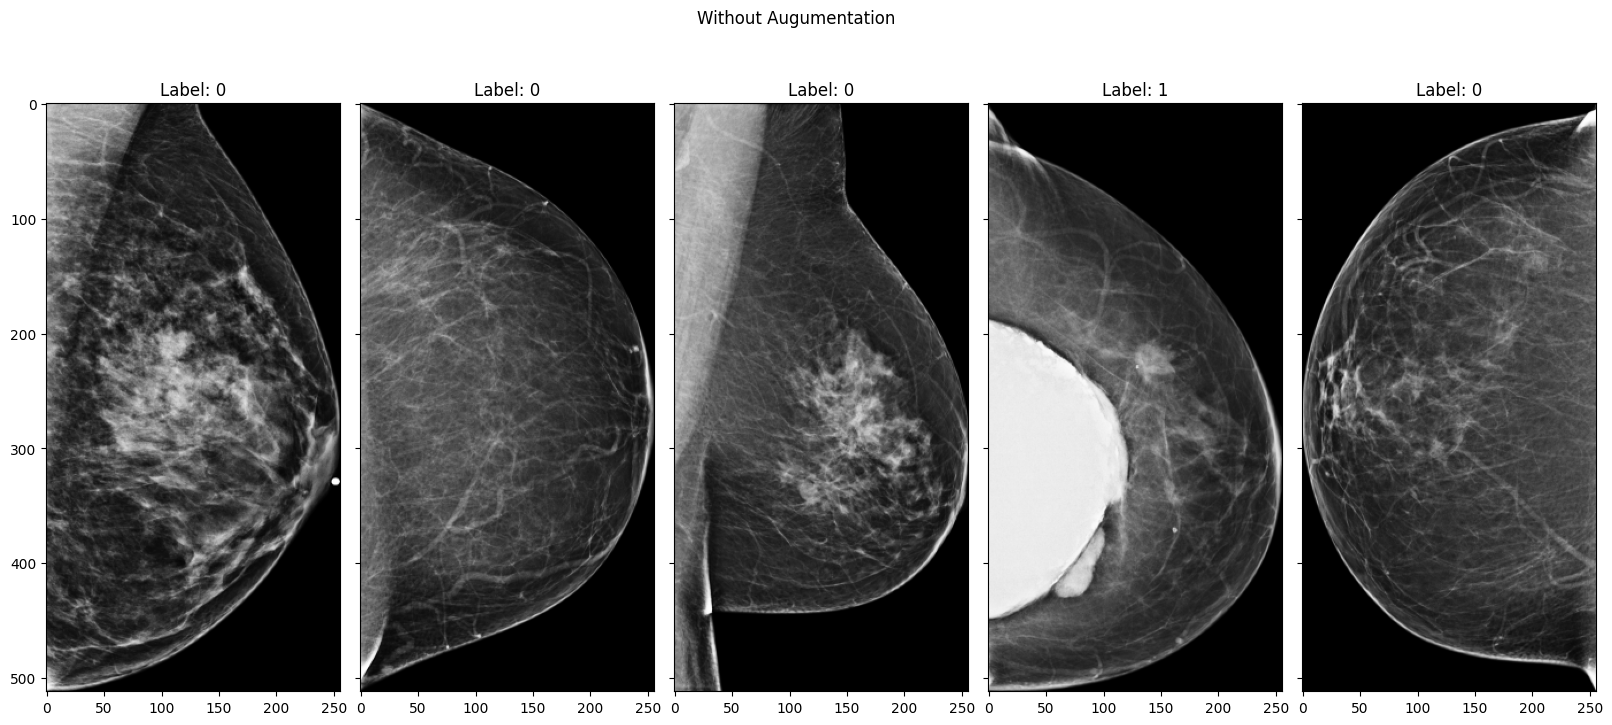

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Number of images in batch :  2


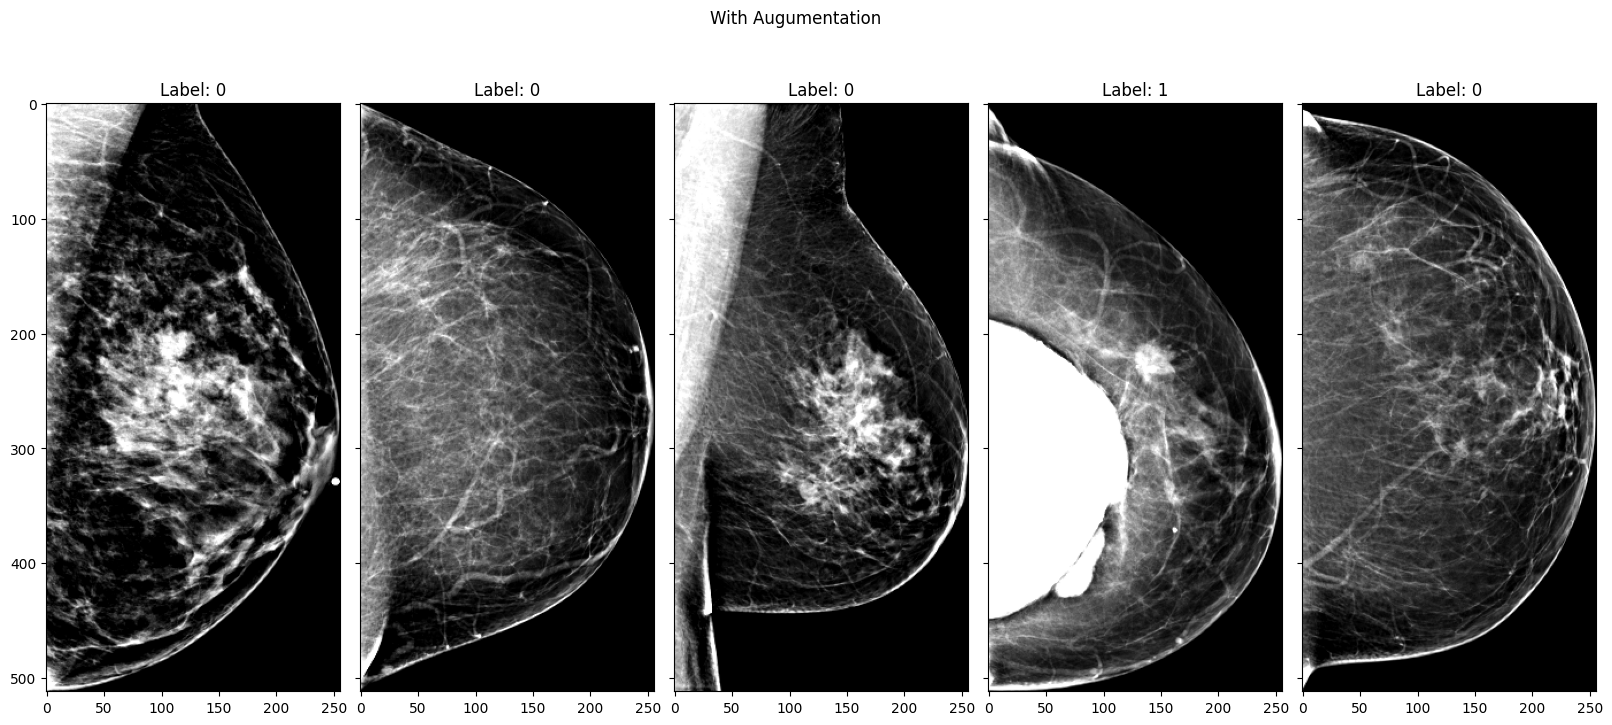

In [33]:
def show_images(dataset,  title="", rows=1, cols=5, figsize=(20, 8)):
    fig = plt.figure(figsize=figsize)
    grid = ImageGrid(fig, 111, nrows_ncols=(rows, cols), axes_pad=0.2)
    for i, (images, labels) in enumerate(dataset.take(1)):
        print("Number of images in batch : ",len(images))
        for j in range(rows*cols):
            grid[j].imshow(images['input_image'][j].numpy())
            grid[j].set_title(f"Label: {labels[j].numpy()}")
    plt.suptitle(title)
    plt.show()

sample_with_augument = build_dataset(train_df, input_features, batch_size=config.batch_size, label=True, 
                                     shuffle=False, augment=True, repeat=False, cache=False, ext=config.img_ext)
sample_without_augument = build_dataset(train_df, input_features, batch_size=config.batch_size, label=True, 
                                        shuffle=False, augment=False, repeat=False, cache=False, ext=config.img_ext)

show_images(sample_without_augument, title="Without Augumentation")
show_images(sample_with_augument, title="With Augumentation")

# 17. Normalization

In [34]:
train_df[input_features] = (train_df[input_features] - train_df[input_features].mean()) / train_df[input_features].std()
train_df[input_features] = train_df[input_features].astype('float32')

In [35]:
train_df[input_features]

,age_bin,biopsy,density_A,density_B,density_C,density_D,density_E,difficult_negative_case_False,difficult_negative_case_True,implant,invasive,laterality_L,laterality_R,view_CC,view_MLO
0,-1.101988,4.267615,-0.206664,-0.532366,1.854993,-0.181727,-0.962214,-2.574287,2.574287,-0.153356,-0.110153,1.007528,-1.007528,-0.964143,0.964143
1,0.001103,-0.234089,-0.206664,-0.532366,-0.538546,-0.181727,1.038231,0.388069,-0.388069,-0.153356,-0.110153,1.007528,-1.007528,1.036154,-1.036154
2,1.104194,-0.234089,-0.206664,-0.532366,-0.538546,-0.181727,1.038231,0.388069,-0.388069,-0.153356,-0.110153,1.007528,-1.007528,-0.964143,0.964143
3,1.104194,4.267615,-0.206664,1.876529,-0.538546,-0.181727,-0.962214,0.388069,-0.388069,6.514275,9.069234,1.007528,-1.007528,1.036154,-1.036154
4,-1.101988,-0.234089,-0.206664,-0.532366,-0.538546,-0.181727,1.038231,0.388069,-0.388069,-0.153356,-0.110153,-0.991536,0.991536,1.036154,-1.036154
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,0.001103,-0.234089,-0.206664,-0.532366,-0.538546,-0.181727,1.038231,-2.574287,2.574287,-0.153356,-0.110153,1.007528,-1.007528,-0.964143,0.964143
996,-1.101988,-0.234089,-0.206664,-0.532366,-0.538546,-0.181727,1.038231,0.388069,-0.388069,-0.153356,-0.110153,1.007528,-1.007528,1.036154,-1.036154
997,0.001103,-0.234089,-0.206664,-0.532366,-0.538546,-0.181727,1.038231,0.388069,-0.388069,-0.153356,-0.110153,-0.991536,0.991536,1.036154,-1.036154
998,0.001103,-0.234089,-0.206664,-0.532366,-0.538546,-0.181727,1.038231,0.388069,-0.388069,-0.153356,-0.110153,1.007528,-1.007528,-0.964143,0.964143


# 18. Evaluation Metrics

In [36]:
def p_f1(y_true, y_pred):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)
    
    tp = tf.reduce_sum(y_true * y_pred)
    tn = tf.reduce_sum((1 - y_true) * (1 - y_pred))
    fp = tf.reduce_sum((1 - y_true) * y_pred)
    fn = tf.reduce_sum(y_true * (1 - y_pred))
    
    p = tp / (tp + fp + tf.keras.backend.epsilon())
    r = tp / (tp + fn + tf.keras.backend.epsilon())
    
    f1 = 2 * p * r / (p + r + tf.keras.backend.epsilon())
    f1 = tf.where(tf.math.is_nan(f1), tf.zeros_like(f1), f1)

    return tf.reduce_mean(f1)

def p_f1_np(y_true, y_pred):
    y_true = y_true.astype(np.float32)
    y_pred = y_pred.astype(np.float32)
    
    tp = np.sum(y_true * y_pred)
    tn = np.sum((1 - y_true) * (1 - y_pred))
    fp = np.sum((1 - y_true) * y_pred)
    fn = np.sum(y_true * (1 - y_pred))
    
    p = tp / (tp + fp + np.finfo(np.float32).eps)
    r = tp / (tp + fn + np.finfo(np.float32).eps)
    
    f1 = 2 * p * r / (p + r + np.finfo(np.float32).eps)
    f1 = np.where(np.isnan(f1), np.zeros_like(f1), f1)

    return np.mean(f1)

# 19.Model Building

In [37]:
def build_model(input_features, 
                loss=config.loss, 
                dropout=config.dropout, 
                optimizer=config.optimizer, 
                img_size=config.img_size):
    with strategy.scope():
#         input_image = tf.keras.layers.Input(shape=(*img_size,3), name='input_image')
        input_image = tf.keras.Input((*img_size, 3), name='input_image')
        input_features = tf.keras.layers.Input(shape=[len(input_features)], name='input_features')
        
        efficientNetBase_model = tf.keras.applications.EfficientNetB3(input_shape=(*img_size,3),
                                                 include_top=False, 
                                                 drop_connect_rate=0.3,
                                                 weights='imagenet')(input_image)
        
        x = tf.keras.layers.MaxPooling2D()(efficientNetBase_model)
        x = tf.keras.layers.Flatten()(x)
        output_image = tf.keras.layers.Dropout(dropout)(x)
        output_image = tf.keras.layers.Dense(32, activation="relu")(output_image)
        output_image = tf.keras.layers.BatchNormalization()(output_image)
        output_image = tf.keras.layers.Dropout(dropout)(output_image)
        output_image = tf.keras.layers.Concatenate()([output_image, input_features])
        output_image = tf.keras.layers.Dense(1, activation='sigmoid')(output_image)
                
        model = tf.keras.Model(inputs=[input_image, input_features], outputs=output_image)
        model.compile(optimizer=optimizer,
              loss=loss,
              metrics=['accuracy', 
                       p_f1])

        return model


# 20. Model Summary

In [38]:
model = build_model(input_features,config.loss,config.dropout,config.optimizer,config.img_size)
model.summary()

43941136/43941136 [==============================] - 0s 0us/step
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_image (InputLayer)       [(None, 512, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 efficientnetb3 (Functional)    (None, 16, 8, 1536)  10783535    ['input_image[0][0]']            
                                                                                                  
 max_pooling2d (MaxPooling2D)   (None, 8, 4, 1536)   0           ['efficientnetb3[0][0]']         
                                                                                                  
 flatten (Flatten)           

# 21. Ploting the model 

In [39]:
tf.keras.utils.plot_model(model, show_shapes=True, dpi=64)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model/model_to_dot to work.


# 22. Defining Model Compilation

In [40]:

##tf.keras.metrics.AUC(name='auc')

# 23 Defining callback function saving models to output directory

In [41]:
# Create directory model weightes saving
save_model_dir = os.path.join(config.output_path,'models')
os.makedirs(os.path.dirname(save_model_dir), exist_ok=True)

In [42]:
def get_callbacks(batch_size, fold, patience=config.patience):
    early_stop = tf.keras.callbacks.EarlyStopping(monitor="val_loss", 
                                             mode="min",
                                             patience=patience,
                                             restore_best_weights=True)
    
    best_model = tf.keras.callbacks.ModelCheckpoint(f'{save_model_dir}/model_{fold}.h5', 
                                                    monitor='val_p_f1',
                                                    mode='max', 
                                                    save_freq='epoch', 
                                                    save_best_only=True, 
                                                    save_weights_only=False,
                                                    verbose=1)
    callbacks_list = [early_stop, 
                      best_model,
#                       lr_scheduler(batch_size)
                     ]
    return callbacks_list

# 24. Training 

In [43]:
results = {}

for fold in range(config.folds):
    
    if fold in config.train_folds:
        continue
    
    
    
    print(f'\n- Fold [{fold}] as validation set, and folds {[i for i in range(config.folds) if i != fold]} as training set\n')
    
    train = train_df.query("fold != @fold")
    validation = train_df.query("fold == @fold")
    
    print("number of examples in training : ",len(train))
    print("number of examples in validation : ",len(validation))

    if config.oversampling:
        
        numberofCancers=train.query('cancer == 1')
        numberofNonCancer=train.query('cancer == 0')
        
        print("numberofCancers :",len(numberofCancers))
        print("numberofNonCancer :",len(numberofNonCancer))
        
        positive = train.query('cancer == 1').sample(frac=config.oversampling_factor, replace=True, 
                                                     random_state=config.seed)
        negative = train.query('cancer == 0')
        train = pd.concat([positive, negative], axis=0).reset_index(drop=True)
        print("number of examples in after upsampling : ",len(train))
    
    train_dataset = build_dataset(train, input_features, batch_size=config.batch_size, 
                                  shuffle=True, augment=True, repeat=False, cache=True)
          
    val_dataset = build_dataset(validation, input_features, batch_size=config.batch_size, 
                                shuffle=False, augment=False, repeat=False, cache=True)
    
    class_weight = compute_class_weight(class_weight='balanced',
                                        classes=train["cancer"].unique(),
                                        y=train["cancer"].values)
    
    model = build_model(input_features)
    
    history = model.fit(train_dataset, 
                        validation_data = val_dataset, 
                        epochs = config.epochs,
                        callbacks = get_callbacks(config.batch_size, fold),
                        class_weight = dict(zip(train["cancer"].unique(), class_weight)),
                        steps_per_epoch = len(train) // config.batch_size)
    
    print('========================out-of-fold predictions ============================================')
    print('======== Loading saved model ========================')
    model.load_weights(f'{save_model_dir}/model_{fold}.h5')

    print('================Predicting OOF validation set ========================')
    b_val_dataset = build_dataset(validation, input_features,
                                  batch_size=config.batch_size, 
                                  shuffle=False, augment=True, repeat=False, cache=True)
    
    #Remove singleton dimensionality with squeeze function
    validation['pred'] = np.squeeze(model.predict(b_val_dataset, verbose=1).astype('float32'))
    validation['pred'] = (validation['pred'] > config.threshold).astype(int)



    print(' ================Compute metrics========================')
    pf = p_f1_np(validation['cancer'], validation['pred'])
    auc = roc_auc_score(validation['cancer'], validation['pred'])
    accuracy = accuracy_score(validation['cancer'], validation['pred'])

    
    results[fold] = {'p_f1': pf,'accuracy': accuracy}
    #'auc': auc,
    print(f'- P-F1: {pf}, Accuracy: {accuracy}\n')
    # AUC: {auc},
    
    del model
    gc.collect()
    tf.keras.backend.clear_session()
    


- Fold [3] as validation set, and folds [0, 1, 2, 4] as training set

number of examples in training :  800
number of examples in validation :  200
numberofCancers : 14
numberofNonCancer : 786
number of examples in after upsampling :  926
Epoch 1/12


2023-04-25 11:51:55.561877: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:903] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node Adam/Adam/AssignAddVariableOp.
2023-04-25 11:51:58.280663: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:903] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node Adam/Adam/AssignAddVariableOp.


3/3 [==============================] - ETA: 0s - loss: 1.0002 - accuracy: 0.5443 - p_f1: 0.2707

2023-04-25 11:53:33.642132: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:903] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.
2023-04-25 11:53:34.335508: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:903] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.



Epoch 1: val_p_f1 improved from -inf to 0.04359, saving model to /kaggle/working/models/model_3.h5
3/3 [==============================] - 207s 37s/step - loss: 1.0002 - accuracy: 0.5443 - p_f1: 0.2707 - val_loss: 1.0287 - val_accuracy: 0.3400 - val_p_f1: 0.0436
Epoch 2/12
3/3 [==============================] - ETA: 0s - loss: 0.4249 - accuracy: 0.6940 - p_f1: 0.3948
Epoch 2: val_p_f1 improved from 0.04359 to 0.04556, saving model to /kaggle/working/models/model_3.h5
3/3 [==============================] - 6s 3s/step - loss: 0.4249 - accuracy: 0.6940 - p_f1: 0.3948 - val_loss: 0.1160 - val_accuracy: 0.9600 - val_p_f1: 0.0456
Epoch 3/12
3/3 [==============================] - ETA: 0s - loss: 0.3416 - accuracy: 0.7279 - p_f1: 0.4212
Epoch 3: val_p_f1 did not improve from 0.04556
3/3 [==============================] - 3s 1s/step - loss: 0.3416 - accuracy: 0.7279 - p_f1: 0.4212 - val_loss: 0.0883 - val_accuracy: 0.9800 - val_p_f1: 0.0153
Epoch 4/12
3/3 [==============================] - ETA:

2023-04-25 11:55:25.010731: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:903] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.
2023-04-25 11:55:25.606655: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:903] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.


1/1 [==============================] - 63s 63s/step
 ================Compute metrics========================
- P-F1: 0.0, Accuracy: 0.955


- Fold [4] as validation set, and folds [0, 1, 2, 3] as training set

number of examples in training :  800
number of examples in validation :  200
numberofCancers : 13
numberofNonCancer : 787
number of examples in after upsampling :  917
Epoch 1/12


2023-04-25 11:57:35.376258: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:903] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node Adam/Adam/AssignAddVariableOp.
2023-04-25 11:57:37.886700: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:903] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node Adam/Adam/AssignAddVariableOp.


3/3 [==============================] - ETA: 0s - loss: 0.8293 - accuracy: 0.5560 - p_f1: 0.3053

2023-04-25 11:58:40.418357: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:903] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.
2023-04-25 11:58:41.009588: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:903] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.



Epoch 1: val_p_f1 improved from -inf to 0.05025, saving model to /kaggle/working/models/model_4.h5
3/3 [==============================] - 169s 38s/step - loss: 0.8293 - accuracy: 0.5560 - p_f1: 0.3053 - val_loss: 2.4950 - val_accuracy: 0.0250 - val_p_f1: 0.0502
Epoch 2/12
3/3 [==============================] - ETA: 0s - loss: 0.4388 - accuracy: 0.6172 - p_f1: 0.3738
Epoch 2: val_p_f1 improved from 0.05025 to 0.06432, saving model to /kaggle/working/models/model_4.h5
3/3 [==============================] - 6s 3s/step - loss: 0.4388 - accuracy: 0.6172 - p_f1: 0.3738 - val_loss: 0.8693 - val_accuracy: 0.3150 - val_p_f1: 0.0643
Epoch 3/12
3/3 [==============================] - ETA: 0s - loss: 0.3820 - accuracy: 0.6615 - p_f1: 0.3847
Epoch 3: val_p_f1 improved from 0.06432 to 0.07192, saving model to /kaggle/working/models/model_4.h5
3/3 [==============================] - 6s 3s/step - loss: 0.3820 - accuracy: 0.6615 - p_f1: 0.3847 - val_loss: 0.6299 - val_accuracy: 0.6000 - val_p_f1: 0.0719

2023-04-25 12:00:58.076720: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:903] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.
2023-04-25 12:00:58.690896: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:903] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.


1/1 [==============================] - 64s 64s/step
 ================Compute metrics========================
- P-F1: 0.0, Accuracy: 0.975



# 25. Plot of accuracy and loss functions

In [44]:
def plot_evaluation_metrics(history):
    accuracy = history.history["accuracy"]
    val_accuracy = history.history["val_accuracy"]
    loss = history.history["loss"]
    val_loss = history.history["val_loss"]
    epochs = range(1, len(accuracy) + 1)
    plt.plot(epochs, accuracy, "r", label="Training accuracy")
    plt.plot(epochs, val_accuracy, "g", label="Validation accuracy")
    
    plt.title("Training and validation accuracy")
    plt.legend()
    plt.figure()
    plt.plot(epochs, loss, "r", label="Training loss")
    plt.plot(epochs, val_loss, "g", label="Validation loss")
    plt.title("Training and validation loss")
    plt.legend()
    plt.show()



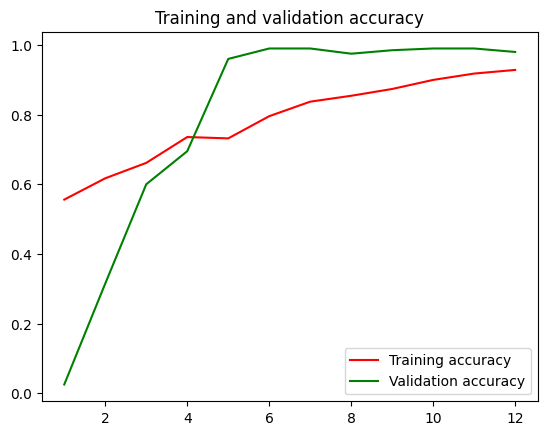

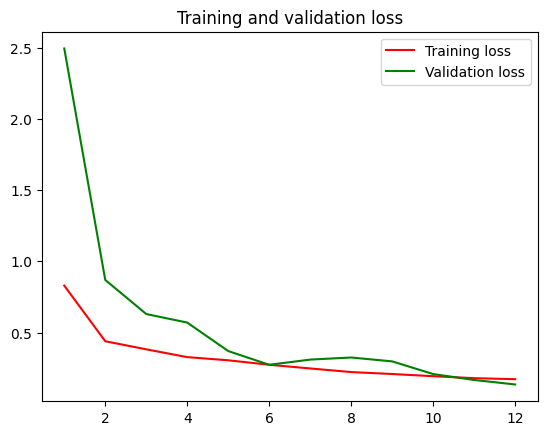

In [45]:
plot_evaluation_metrics(history)